# Anomaly detection by Informer


## 1. Data preprocessing

In [1]:
import numpy as np
import pandas as pd
test_data = np.load('./dataset/KDD99/npy/kdd99_test.npy')[:,:-1]
df = pd.DataFrame(test_data)

In [93]:
test_label = list(map(int,np.load('./dataset/KDD99/npy/kdd99_test.npy')[:,-1]))
df_y = pd.DataFrame(test_label)

In [2]:
import joblib
scaler = joblib.load('./dataset/KDD99/preprocessing/KDD99_standard_scaler.pkl')
trans_df = scaler.transform(df)
norm_data = pd.DataFrame(data=trans_df, index=df.index, columns=df.columns, dtype=None, copy=None)

In [3]:
norm_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
count,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,0.223187,0.162404,-0.120690,0.006433,0.005533,-0.004843,0.006909,0.001036,-0.015861,-0.002806,...,1.021759,-0.864403,-1.398256,0.400320,2.999639,-0.488684,13.330916,20.561261,1.130050,2.431358
std,3.568266,64.031141,1.211397,0.134805,2.892597,0.950018,1.418238,0.996319,0.499510,0.672521,...,0.629102,1.933569,2.756014,1.987914,2.715610,1.342032,28.832428,44.482847,4.782287,9.863147
min,-0.018712,-0.033639,-0.152535,0.000000,-0.001905,-0.046773,-0.006964,-0.004622,-0.021132,-0.005950,...,-1.237057,-4.304583,-6.455519,-0.161994,-0.396556,-0.701570,-0.059358,-0.043280,-0.075275,-0.029140
25%,-0.018712,-0.030723,-0.152535,0.000000,-0.001905,-0.046773,-0.006964,-0.004622,-0.021132,-0.005950,...,1.240666,-3.465807,-3.704744,-0.161994,-0.396556,-0.701570,-0.059358,-0.043280,-0.075275,-0.029140
50%,-0.018712,0.000054,-0.152535,0.000000,-0.001905,-0.046773,-0.006964,-0.004622,-0.021132,-0.005950,...,1.240666,0.345154,0.253687,-0.161994,5.245576,-0.701570,-0.059358,-0.043280,-0.075275,-0.029140
75%,-0.018712,0.033229,-0.152535,0.000000,-0.001905,-0.046773,-0.006964,-0.004622,-0.021132,-0.005950,...,1.240666,0.345154,0.253687,0.565786,5.245576,-0.701570,-0.059358,-0.043280,-0.075275,-0.029140
max,294.060339,44926.924727,188.870379,3.000000,1574.840944,36.394150,456.911539,489.753945,47.322282,172.598505,...,1.240666,0.345154,0.253687,18.032502,5.245576,31.150808,75.697211,116.734290,20.664123,42.827961


In [4]:
norm_data.to_csv("./dataset/KDD99/preprocessing/KDD99_Attack_standard_normalised_normal.csv", mode='w')
#df_y.to_csv("./dataset/KDD99/preprocessing/KDD99_Attack_label.csv", mode='w')

In [540]:
norm_data = pd.read_csv("./dataset/SMAP/preprocessing/SMAP_Attack_standard_normalised_normal.csv")
norm_data = norm_data.set_index('Unnamed: 0')
#norm_data.date = pd.to_datetime(norm_data.date)
#norm_data = norm_data.set_index('date')

In [15]:
df_y = pd.read_csv("./dataset/WADI/WADI_Attack_label.csv")
df_y.date = pd.to_datetime(df_y.date)
df_y = df_y.set_index('date')

In [ ]:
# 일단 안해줘도 될듯 
val_df = norm_data.iloc[37440:37440+6120]
test_df = norm_data.iloc[37440+6120:]

## 2.Time Series Forecasting 

In [1]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import os

In [47]:
import torch

In [48]:
torch.__version__

'1.8.0'

In [2]:
# 12. Informerstack(lr=0.0001)
args = dotdict()

args.model = 'informerstack' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'KDD99' # data
args.root_path = './dataset/KDD99/preprocessing/' # root path of data file
args.data_path = 'KDD99_Attack_standard_normalised_normal.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = '1_AIT_001_PV' # target feature in S or MS task
args.freq = 'y' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 6*60 # input sequence length of Informer encoder
args.label_len = 6*30 # start token length of Informer decoder
args.pred_len = 6*10 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

# 얘네들은 feature 개수 의미하는건가?
args.enc_in = 34 # encoder input size
args.dec_in = 34 # decoder input size
args.c_out = 34 # output size

args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
#args.e_layers = 4 # 4 # num of encoder layers
args.s_layers = [3,2,1]
args.d_layers = 4 # 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'fixed' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = True # whether to output attention in ecoder
args.mix = True
args.padding = 0
#args.freq = 's'

args.batch_size = 64
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type2'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 30
args.patience = 2
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [5]:
# Exp = Exp_Informer
# exp = Exp(args)
# setting = 'informer_SWaT_ftM_sl1080_ll720_pl360_dm512_nh8_el6_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(exp.args.checkpoints, setting)
# best_model_path = path+'/'+'checkpoint.pth'
# exp.model.load_state_dict(torch.load(best_model_path))

In [6]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import StandardScaler

from utils.tools import StandardScaler
from utils.timefeatures import time_features

import warnings
warnings.filterwarnings('ignore')

class Dataset_KDD99_anomaly(Dataset):
    def __init__(self, root_path, flag='train', size=None, 
                 features='S', data_path='ETTh1.csv', 
                 target='OT', scale=False, inverse=False, timeenc=0, freq='h', cols=None, val_test_split=10000):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['test', 'val']
        type_map = {'val':0, 'test':1}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        
        self.root_path = root_path
        self.data_path = data_path
        self.val_test_split = val_test_split
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        border1s = [0, self.val_test_split - self.seq_len]
        border2s = [self.val_test_split, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]

        return seq_x, seq_y, np.array([]), np.array([])
    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [7]:
from utils.metrics import metric
import numpy as np

def predict(setting, val_test='val', load=True):
        test_data, test_loader = data_set, data_loader
        
        if load:
            path = os.path.join(exp.args.checkpoints, setting)
            best_model_path = path+'/'+'checkpoint.pth'
            exp.model.load_state_dict(torch.load(best_model_path))

        exp.model.eval()
        
        preds = []
        trues = []
        
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            if i%args.pred_len == 0 or i+1==len(test_loader):
                #print('{}/{} step'.format(i, len(test_loader)))
                pred, true = _process_one_batch(
                    test_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
                preds.append(pred.detach().cpu().numpy())
                trues.append(true.detach().cpu().numpy())

        preds = np.array(preds)
        trues = np.array(trues)
        
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/anomaly/' + setting +'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))

        np.save(folder_path+val_test+'_metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path+val_test+'_pred.npy', preds)
        np.save(folder_path+val_test+'_true.npy', trues)

        return


In [8]:
def _process_one_batch(dataset_object, batch_x, batch_y, batch_x_mark, batch_y_mark):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)

        return outputs, batch_y

In [73]:
Data = Dataset_KDD99_anomaly
timeenc = 0 if args.embed!='timeF' else 1
val_test_split = int(494021*0.3) # 어디를 기준으로 val, test 자를지
flag = 'test'

shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.freq # batch_size를 1로 하는게 좋긴 할듯

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
setting = 'informerstack_KDD99_ftM_sl360_ll180_pl60_dm512_nh8_elNone_dl4_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0_standard'
predict(setting, flag)
torch.cuda.empty_cache()

test 395158
Use GPU: cuda:0
test shape: (6587, 1, 60, 34) (6587, 1, 60, 34)
test shape: (6587, 60, 34) (6587, 60, 34)
mse:167.9853515625, mae:3.4476819038391113


In [22]:
path = './results/anomaly/'+setting
val_preds = np.load(path+'/val_pred.npy')
val_trues = np.load(path+'/val_true.npy')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


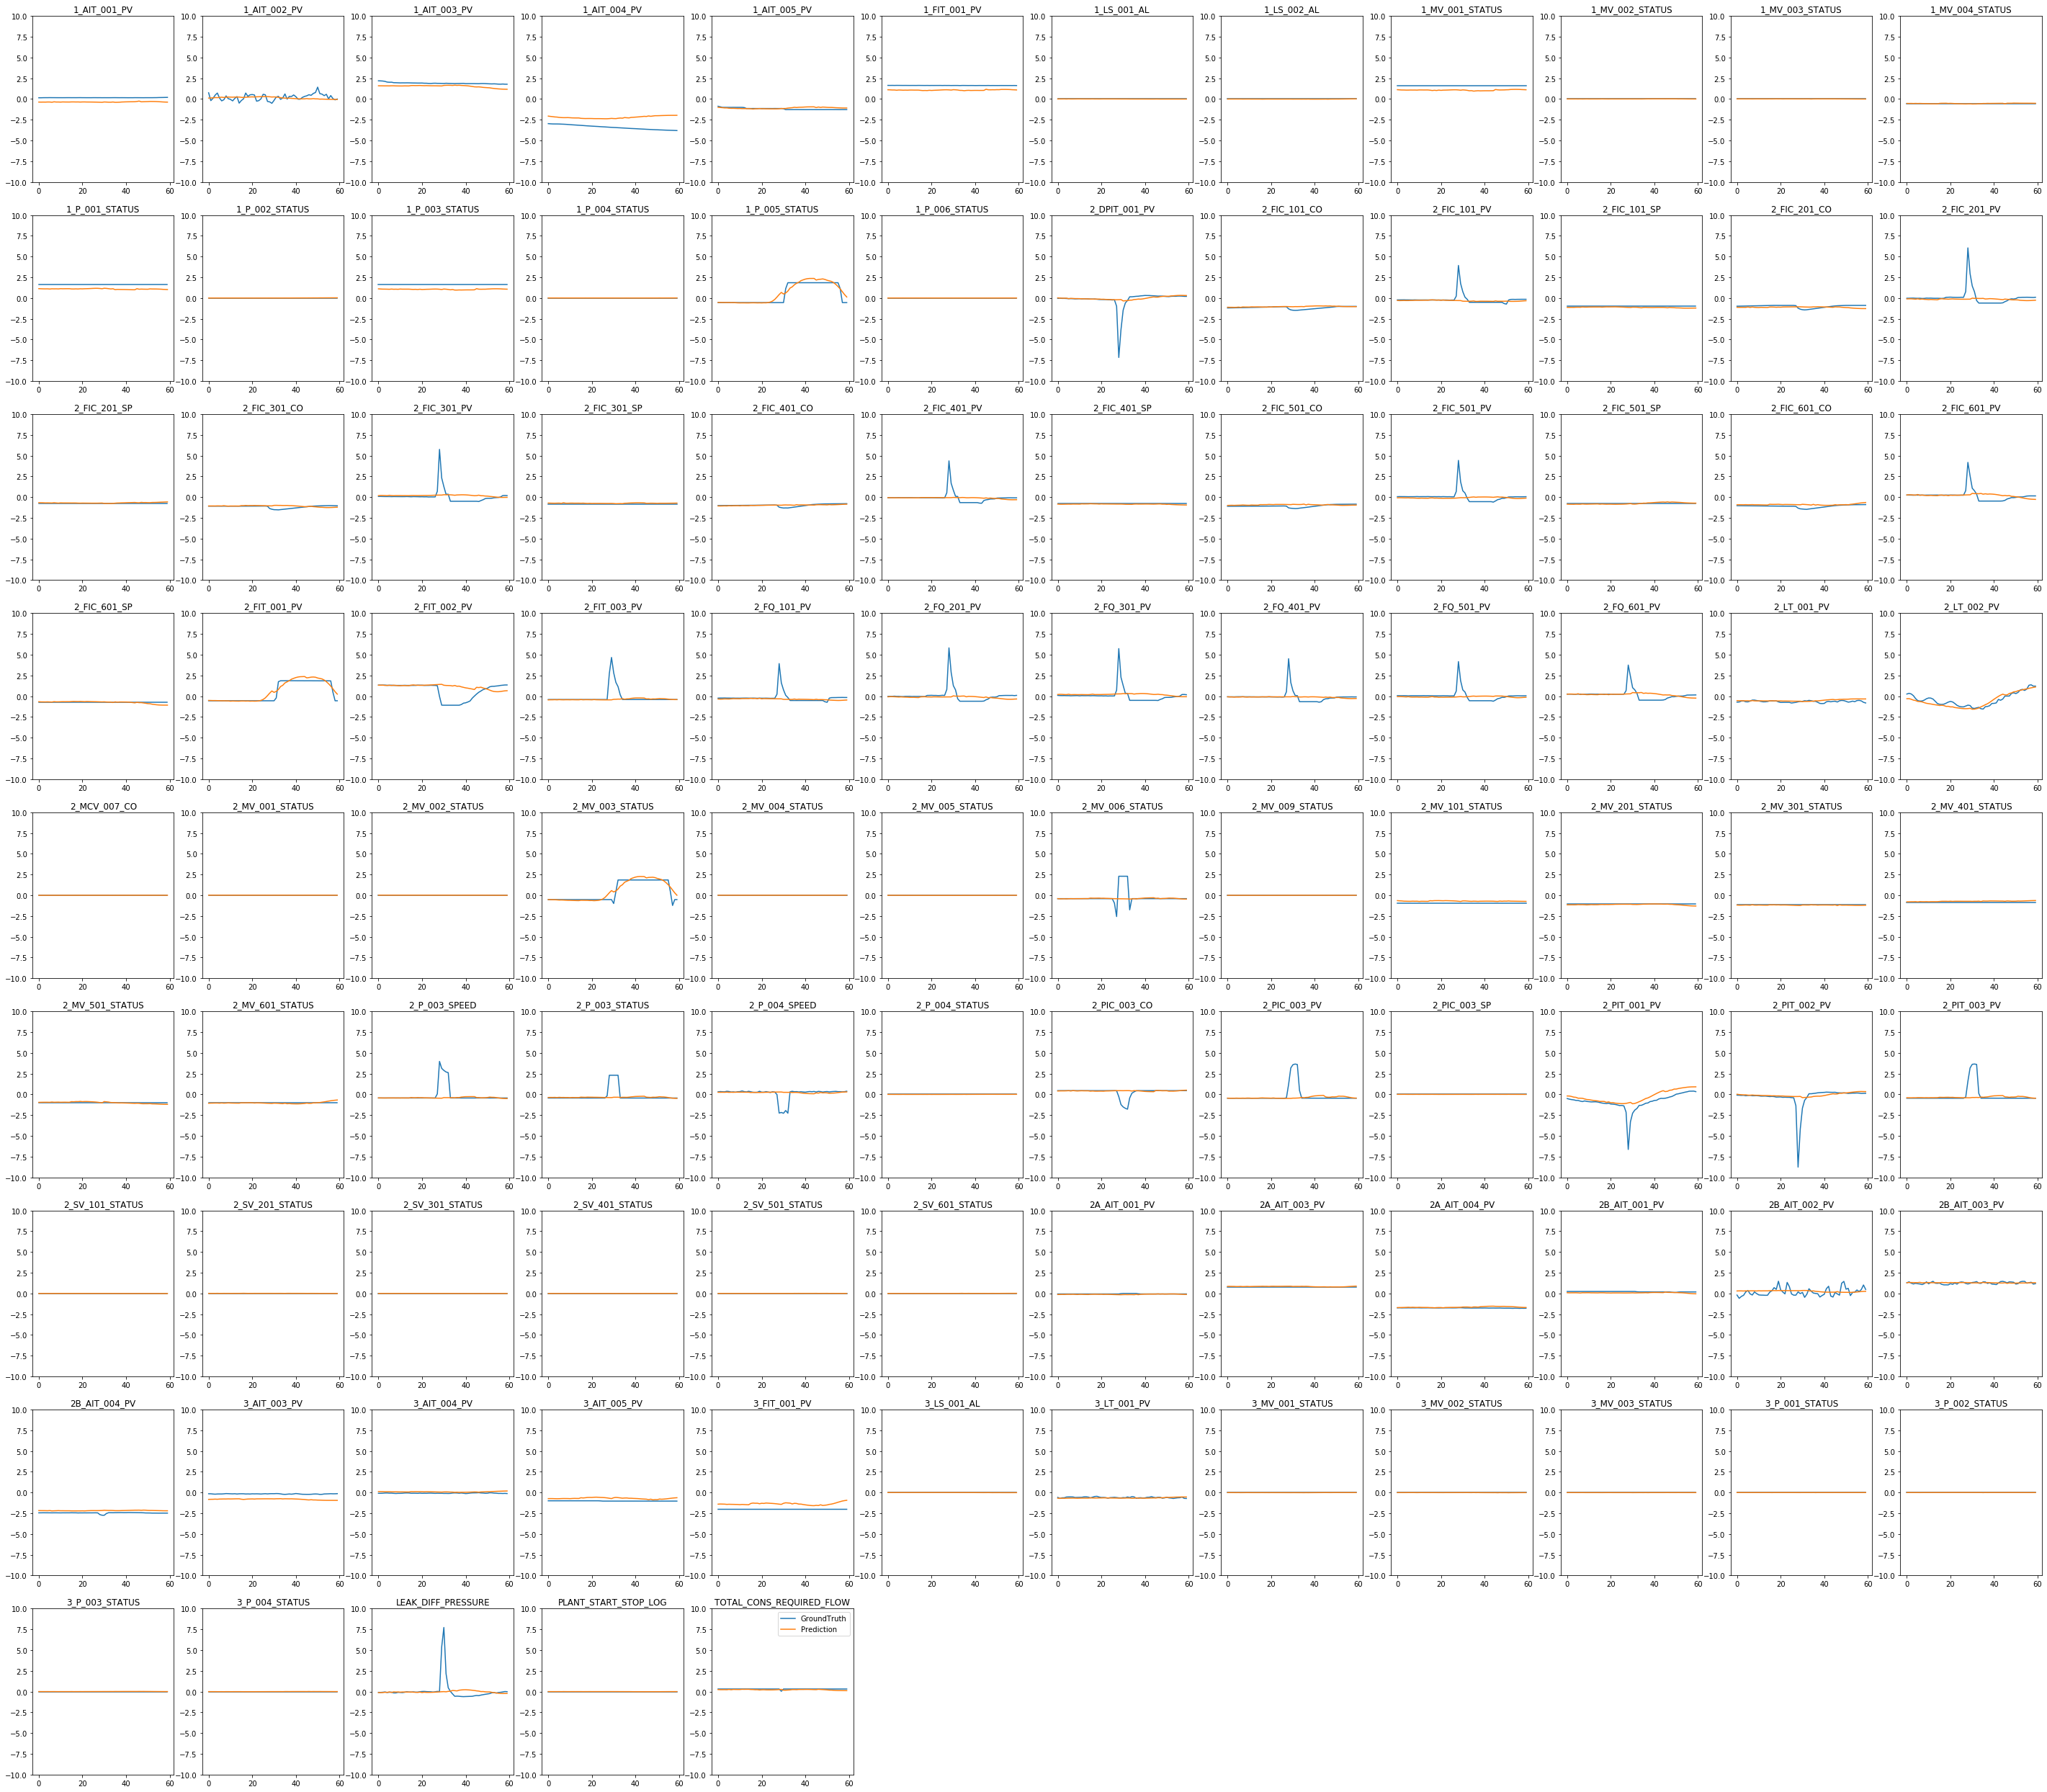

In [33]:
# StandardScaler
# lr=0.0001
# args.seq_len = 6*60*3, args.label_len = 6*60, args.pred_len = 6*30 
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))

idx = 3
 
for i in range(args.enc_in):
    plt.subplot(10, 12, i+1)
    plt.ylim([-10.0, 10.0])    
    plt.plot(val_trues[idx,:,i], label='GroundTruth')
    plt.plot(val_preds[idx,:,i], label='Prediction')
    plt.title(f'{norm_data.columns[i]}')

print(list(val_label.iloc[idx*args.pred_len:(idx+1)*args.pred_len, 0]))
plt.legend()
plt.show()

In [22]:
path = './results/anomaly/'+setting
#val_preds = np.load(path+'/val_pred.npy')
#val_trues = np.load(path+'/val_true.npy')
test_preds = np.load(path+'/test_pred.npy')
test_trues = np.load(path+'/test_true.npy')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


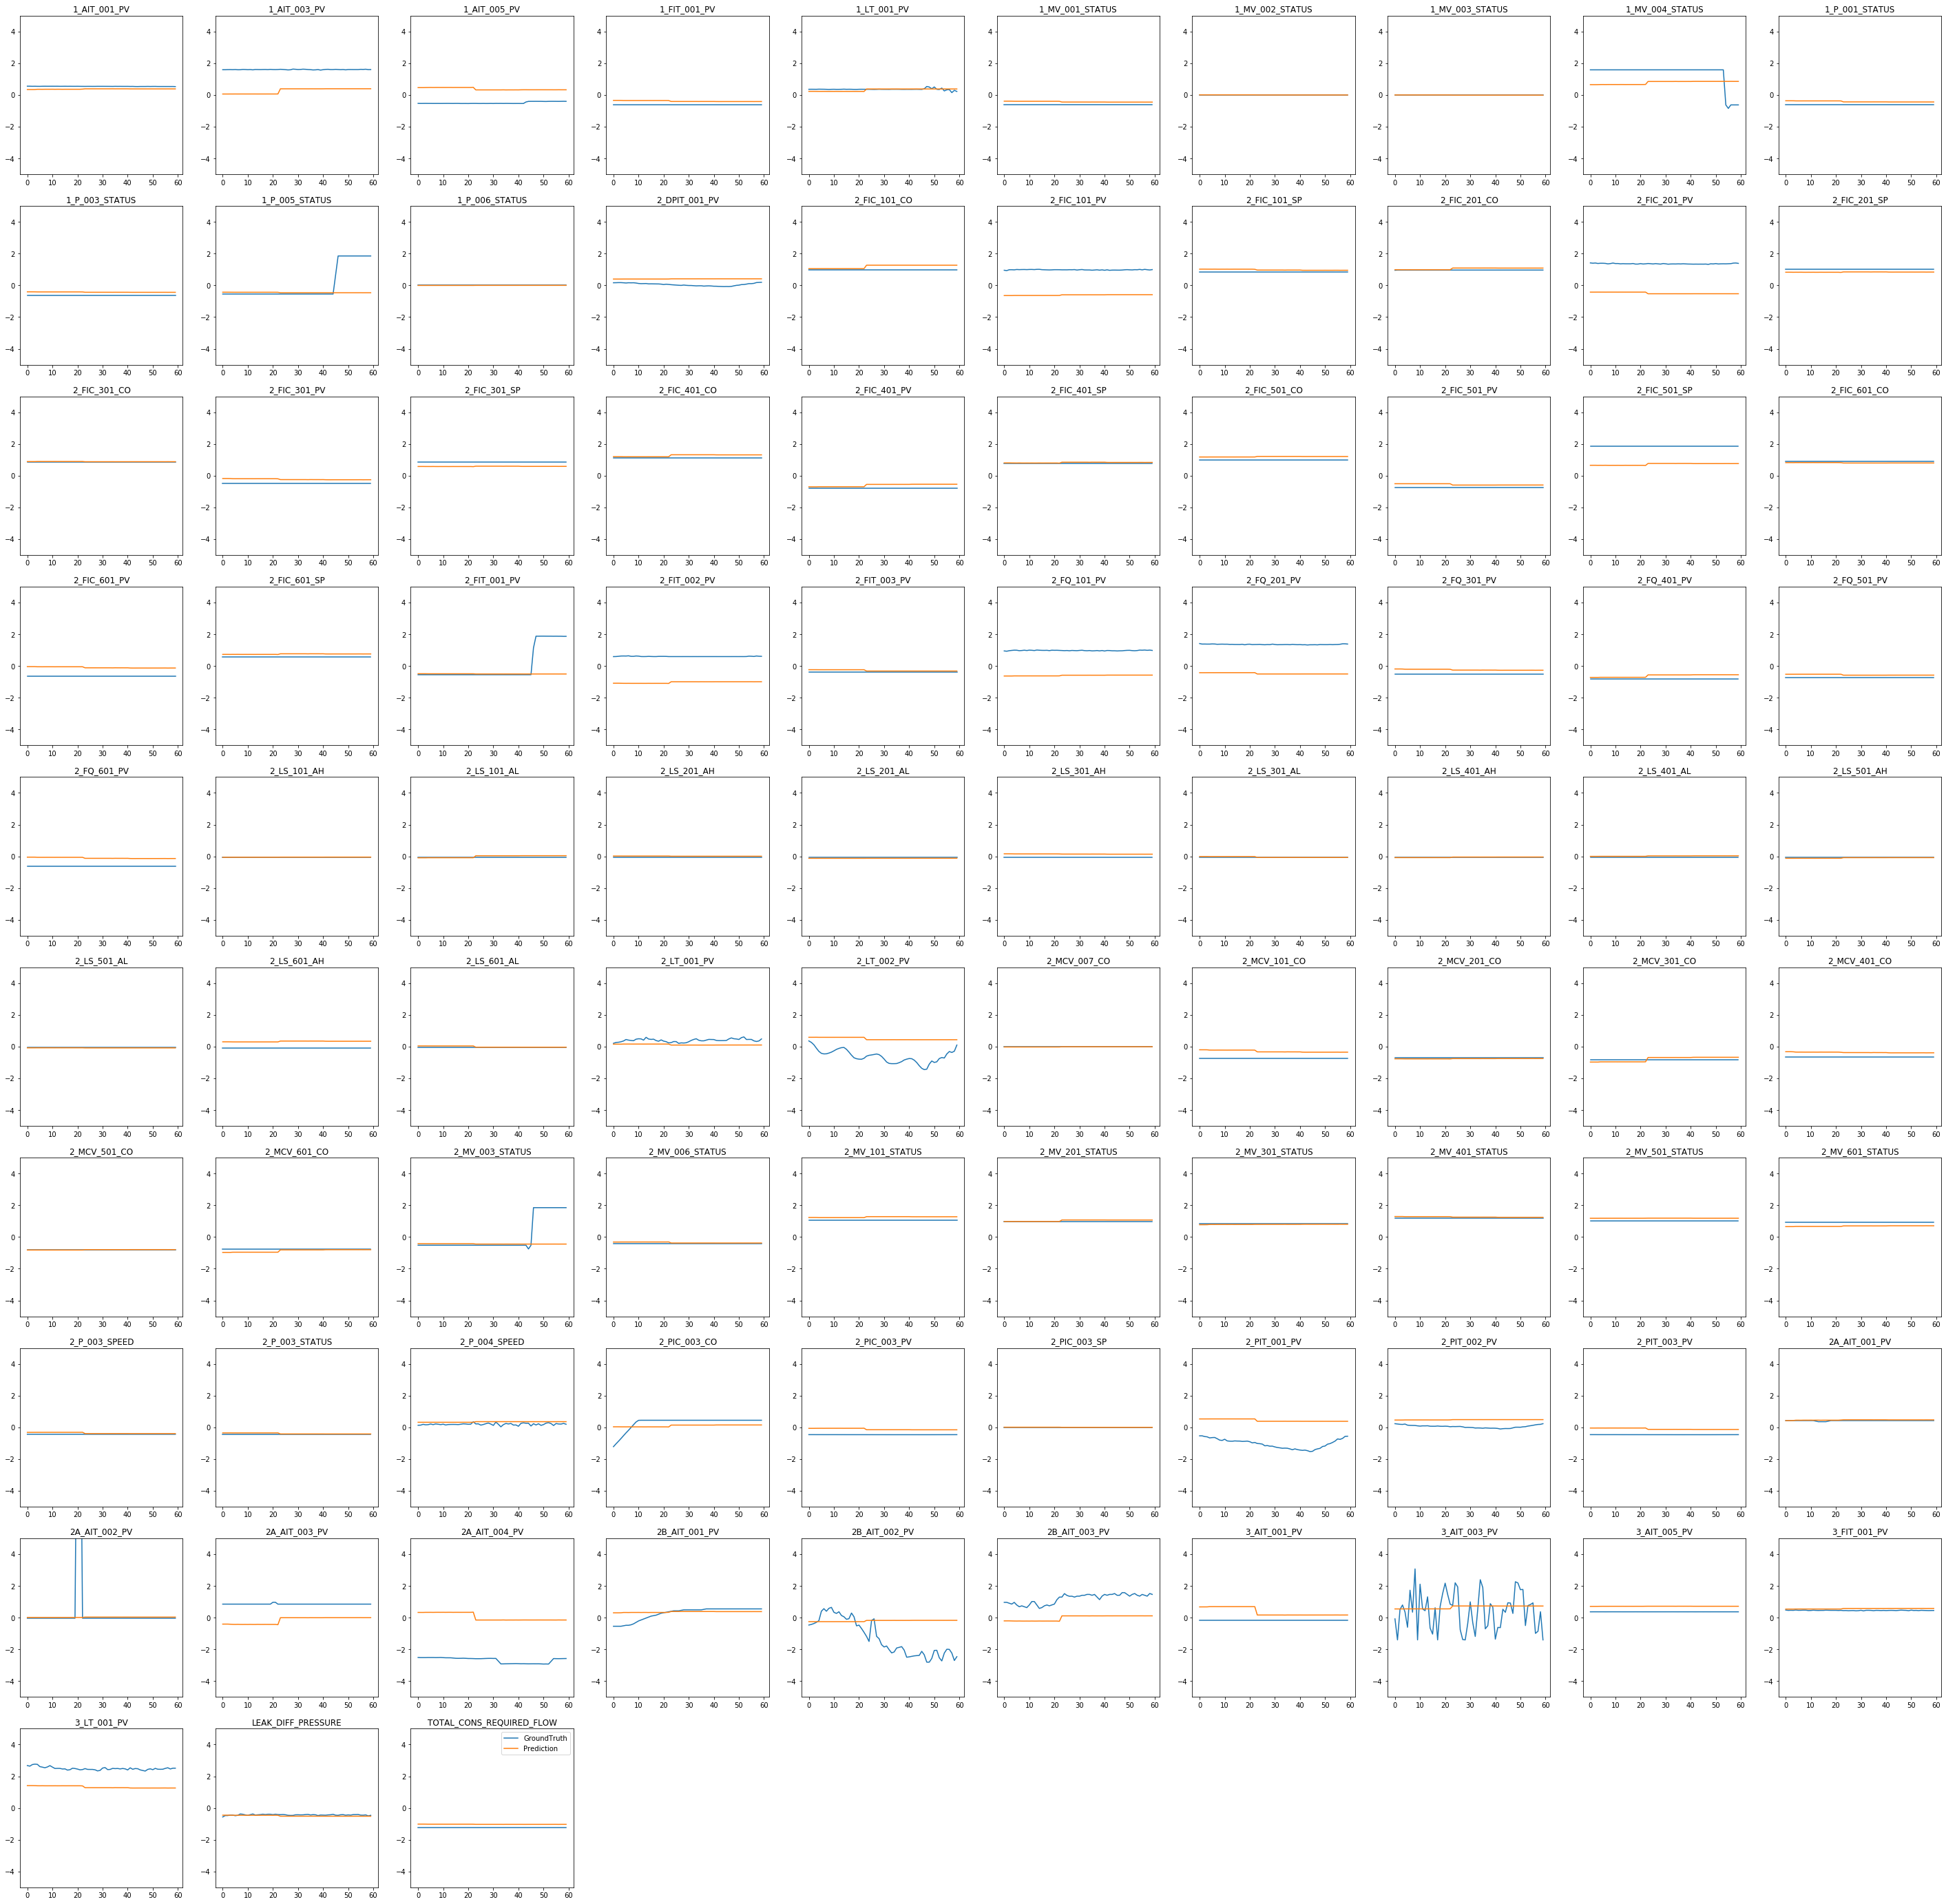

In [25]:
# StandardScaler
# lr=0.0001
# args.seq_len = 6*60*3, args.label_len = 6*60, args.pred_len = 6*30 
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))

idx = 10
 
for i in range(args.enc_in):
    plt.subplot(10, 10, i+1)
    plt.ylim([-5.0, 5.0])    
    
    plt.plot(test_trues[idx,:,i], label='GroundTruth')
    plt.plot(test_preds[idx,:,i], label='Prediction')
    plt.title(f'{norm_data.columns[i]}')

print(list(test_label.iloc[idx*60:(idx+1)*60, 0]))
plt.legend()
plt.show()

## 3. Anomaly detection

In [5]:
import pandas as pd
import numpy as np

In [14]:
val_test_split = int(494021*0.4)
setting = 'informerstack_KDD99_ftM_sl360_ll180_pl60_dm512_nh8_elNone_dl4_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0_standard'

In [15]:
df_y = pd.read_csv("./dataset/KDD99/preprocessing/KDD99_Attack_label.csv").iloc[:,1]
#df_y.date = pd.to_datetime(df_y.date)
#df_y = df_y.set_index('date')

val_label = df_y[args.seq_len:val_test_split]
test_label = df_y[val_test_split:]

len_val = val_label.shape[0]
len_test = test_label.shape[0]

path = './results/anomaly/'+setting
val_preds = np.load(path+'/val_pred.npy').reshape(-1,args.c_out)[:len_val]
val_trues = np.load(path+'/val_true.npy').reshape(-1,args.c_out)[:len_val]
test_preds = np.load(path+'/test_pred.npy').reshape(-1,args.c_out)[:len_test]
test_trues = np.load(path+'/test_true.npy').reshape(-1,args.c_out)[:len_test]

val_err = np.abs(val_preds-val_trues)
test_err = np.abs(test_preds-test_trues)

val_median = np.median(val_err,axis=0)
test_median = np.median(test_err,axis=0)

val_Q1 = np.percentile(val_err, 25, axis = 0) 
val_Q3 = np.percentile(val_err, 75, axis = 0) 
val_IQR = val_Q3 - val_Q1
test_Q1 = np.percentile(test_err, 25, axis = 0) 
test_Q3 = np.percentile(test_err, 75, axis = 0) 
test_IQR = test_Q3 - test_Q1

val_a = np.abs((val_err - val_median)/val_IQR)
#val_a2 = np.delete(val_a,[82],axis=1)
test_a = np.abs((test_err - test_median)/test_IQR)
#test_a2 = np.delete(test_a,[82],axis=1)

val_A = np.max(val_a, axis=1)
test_A = np.max(test_a, axis=1)
#val_A = np.max(val_a2, axis=1)
#test_A = np.max(test_a2, axis=1)

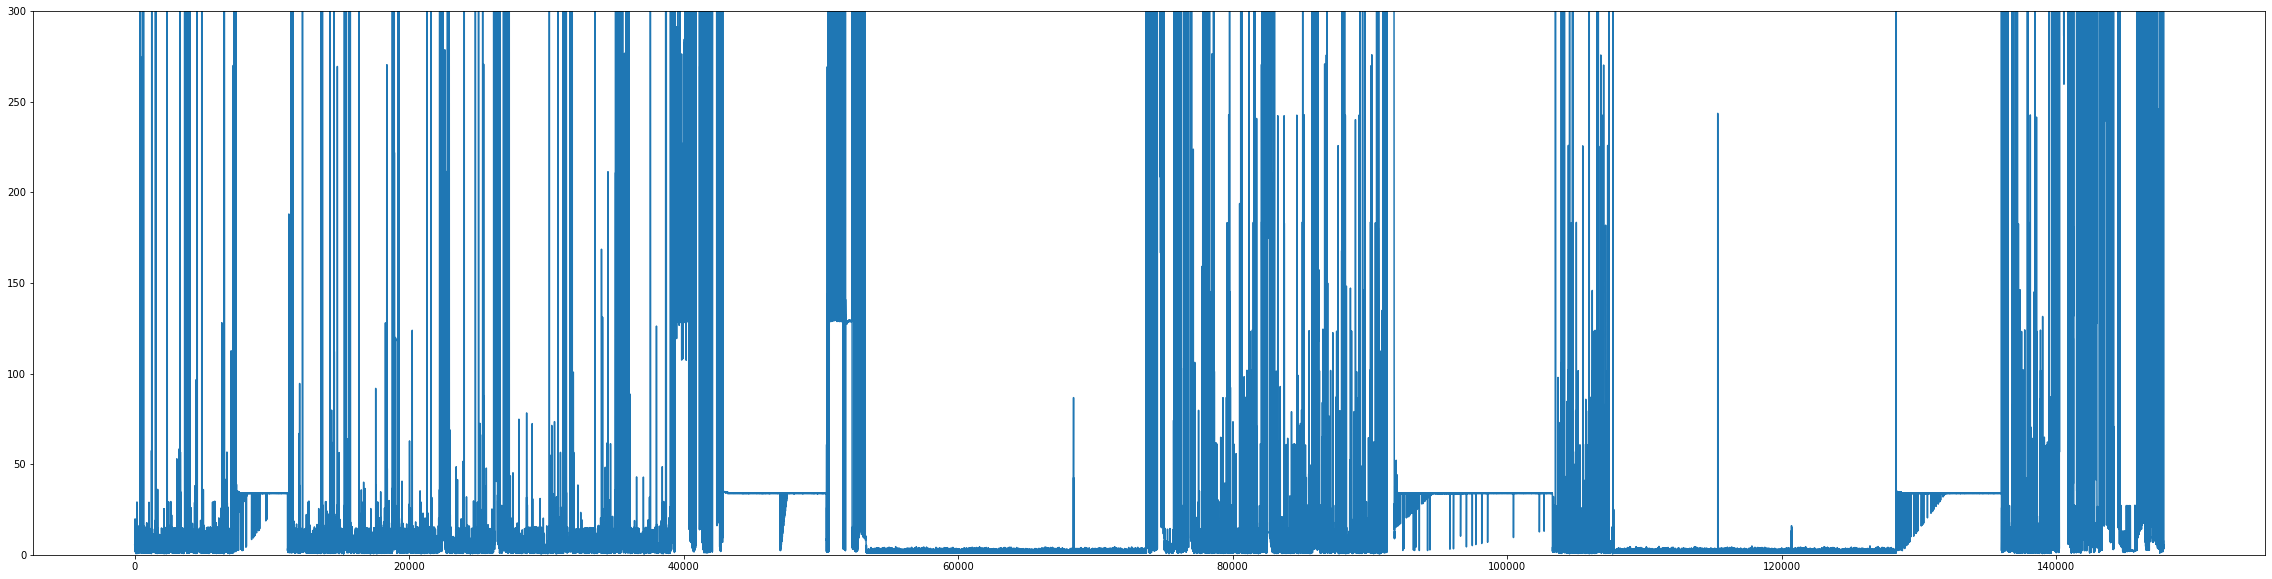

In [137]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,10))
plt.ylim([0.0, 300.0])
plt.plot(val_A)
#plt.plot(np.array(val_label))
plt.show()

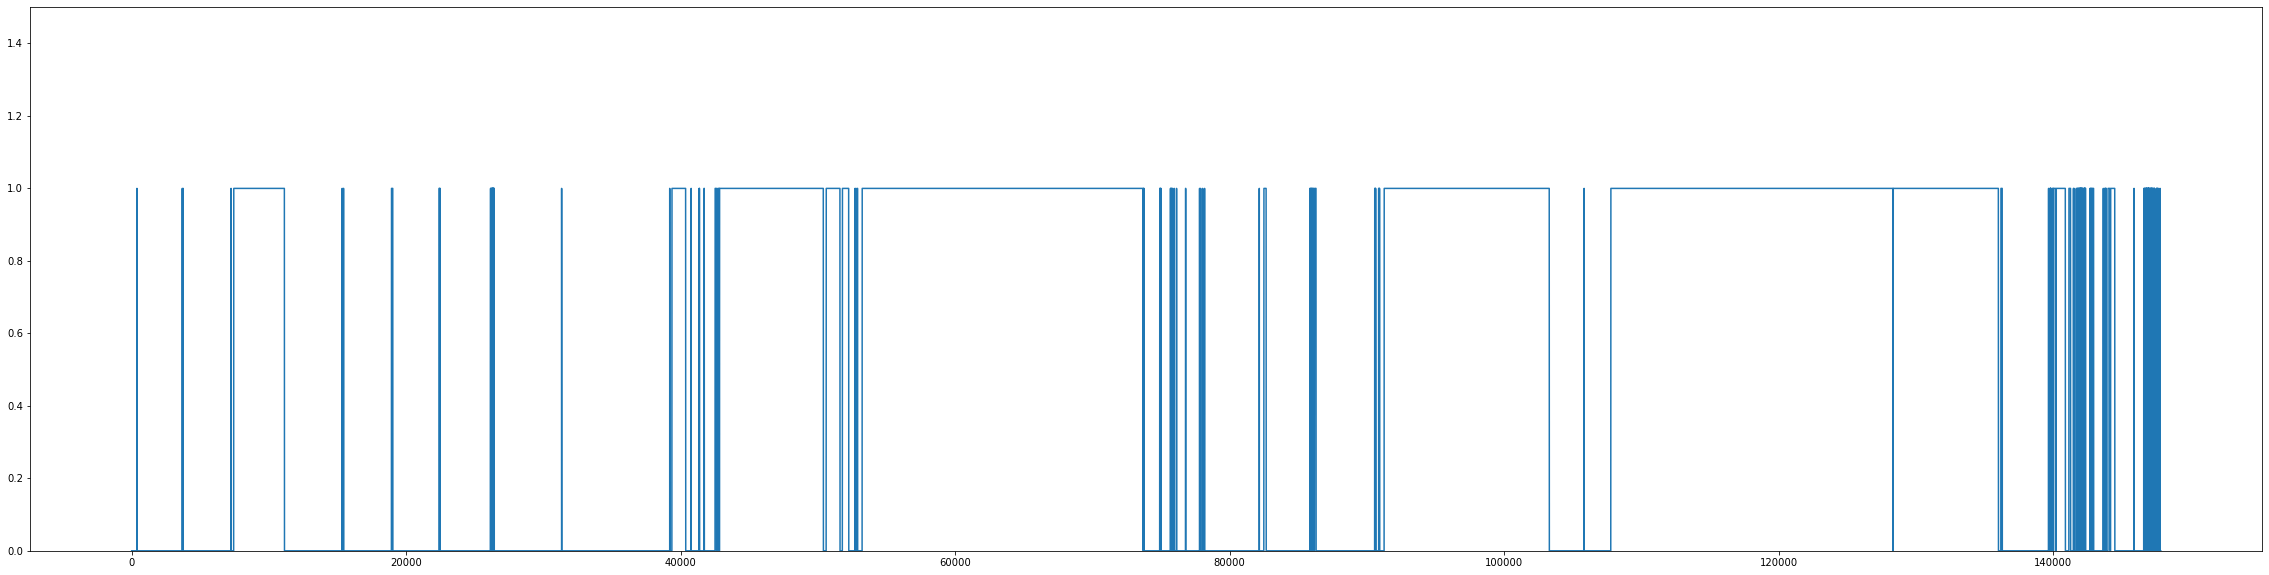

In [128]:
plt.figure(figsize=(40,10))
plt.plot(np.array(val_label))
plt.ylim([0.0, 1.5])
plt.show()

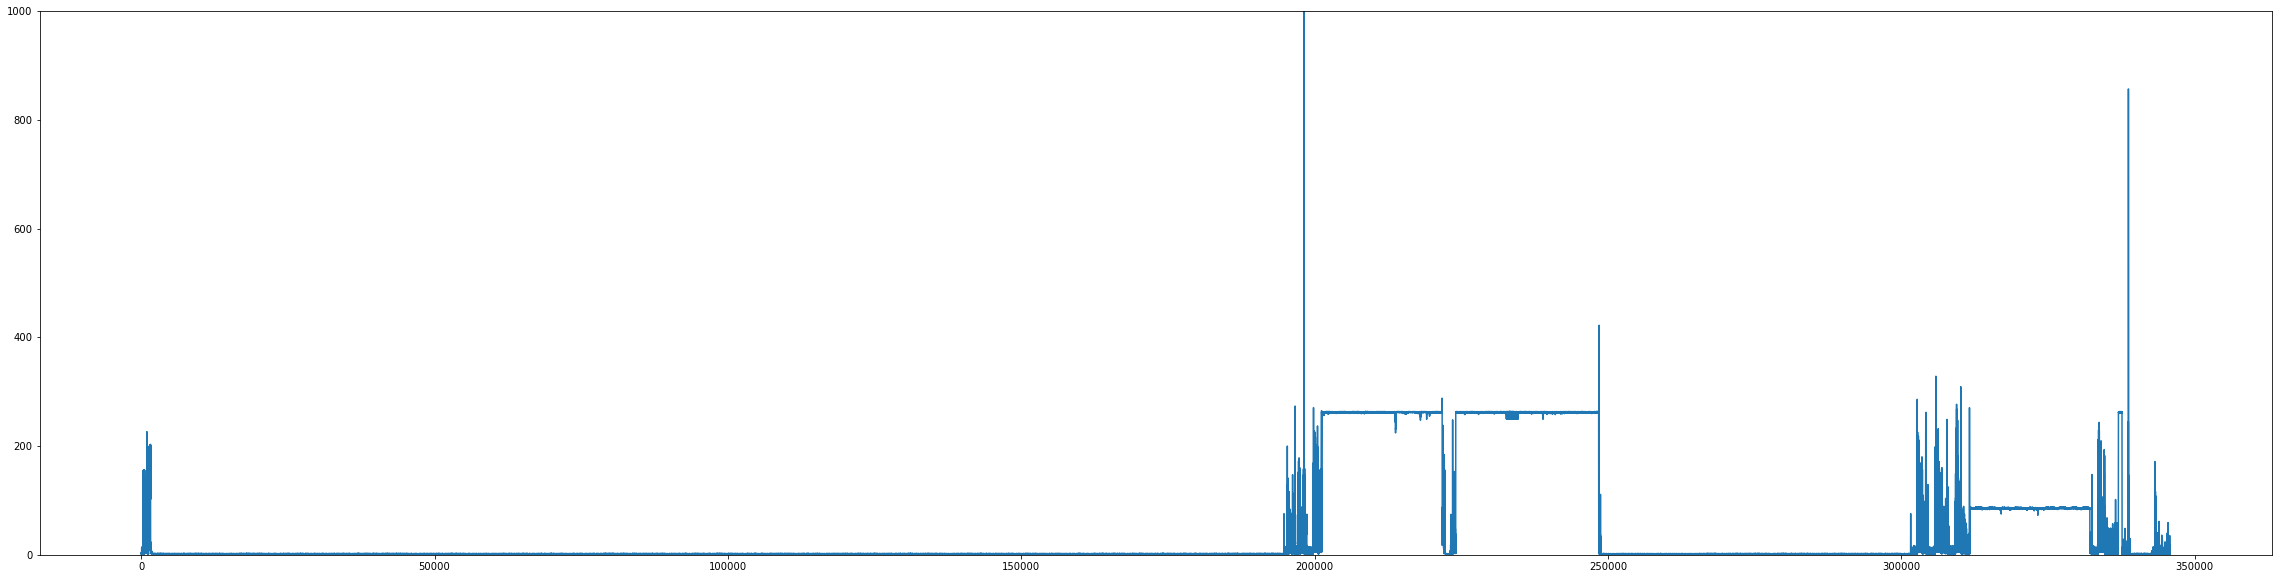

In [131]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,10))
plt.ylim([0.0, 1000.0])
plt.plot(test_A)
#plt.plot(np.array(val_label))
plt.show()

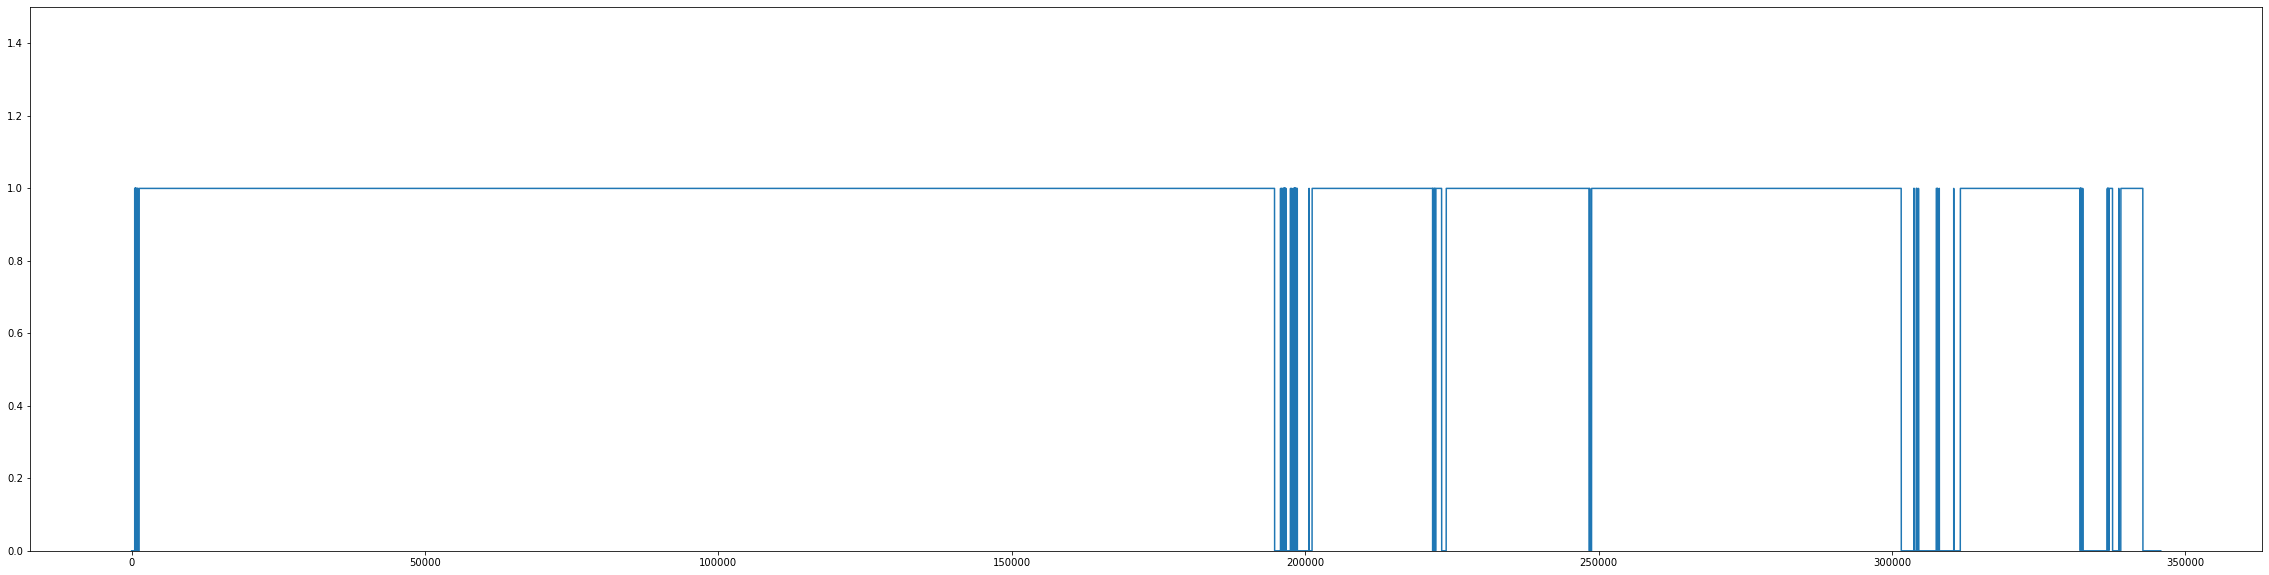

In [60]:
plt.figure(figsize=(40,10))
plt.plot(np.array(test_label))
plt.ylim([0.0, 1.5])
plt.show()

### 3-1 Threshold

In [29]:
val_A[41703] = np.min(val_A)
val_label[41703] = 0

In [10]:
np.argsort(val_A)[-5:]

array([ 15339, 141153,  42706,  39205,  73862])

In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

n_threshold = 100
threshold_list = np.linspace(np.min(val_A), np.max(val_A), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)

#threshold_list = np.linspace(np.min(val_A), 3.0176, n_threshold, endpoint=True)
true = val_label
max_f1 = 0
max_f1_threshold = 0
f1_list = []
for threshold in threshold_list:
    pred = list(map(int, val_A > threshold))
    f1 = f1_score(true, pred)
    f1_list.append(f1)

max_f1_threshold = threshold_list[np.array(f1_list).argmax()]
max_f1_threshold, np.array(f1_list).max()

(0.7645926912399784, 0.7810301301799282)

In [46]:
true = list(test_label)
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.828180161375128, 0.7748520491196923, 0.889391276290428)

In [134]:
true = list(test_label)
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.958998418095423, 0.9998054206053302, 0.9213918606635373)

In [104]:
pred.count(0)

1038

In [135]:
confusion_matrix(true, pred)

array([[     0,  27179],
       [    62, 318574]])

In [272]:
# 15
true = list(test_label)
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.9478970023134694, 0.908478640203869, 0.9908911975627707)

In [276]:
# 20
true = list(test_label)
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.8958671121586503, 0.8141390175623595, 0.9958349168326942)

In [249]:
# 1000
true = list(test_label)
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.9240475734901661, 0.8639042669378225, 0.9931916091182647)

In [242]:
# 2500
true = list(test_label)
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.9232575679947859, 0.8624543366097993, 0.9932843454405477)

In [24]:
confusion_matrix(true, pred)

array([[     0,  27179],
       [  1038, 317598]])

In [ ]:
==============================================

In [51]:
# 18시간 60% 20시간 61.7%
val_test_split = int(494021*0.2)

In [52]:
# SMAP: informerstack_SMAP_ftM_sl360_ll180_pl60_dm512_nh8_elNone_dl4_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0_informerstack_preprocessing2
Data = Dataset_KDD99_anomaly
timeenc = 0 if args.embed!='timeF' else 1
flag = 'val'

shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.freq # batch_size를 1로 하는게 좋긴 할듯

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
setting = 'informerstack_KDD99_ftM_sl360_ll180_pl60_dm512_nh8_elNone_dl4_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0_2'
predict(setting, flag)
torch.cuda.empty_cache()

Data = Dataset_KDD99_anomaly
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'

shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.freq # batch_size를 1로 하는게 좋긴 할듯

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
predict(setting, flag)
torch.cuda.empty_cache()

df_y = pd.read_csv("./dataset/KDD99/preprocessing/KDD99_Attack_label.csv").iloc[:,1]
#df_y.date = pd.to_datetime(df_y.date)
#df_y = df_y.set_index('date')

val_label = df_y[args.seq_len:val_test_split]
test_label = df_y[val_test_split:]

len_val = val_label.shape[0]
len_test = test_label.shape[0]

path = './results/anomaly/'+setting
val_preds = np.load(path+'/val_pred.npy').reshape(-1,args.c_out)[:len_val]
val_trues = np.load(path+'/val_true.npy').reshape(-1,args.c_out)[:len_val]
test_preds = np.load(path+'/test_pred.npy').reshape(-1,args.c_out)[:len_test]
test_trues = np.load(path+'/test_true.npy').reshape(-1,args.c_out)[:len_test]

val_err = np.abs(val_preds-val_trues)
test_err = np.abs(test_preds-test_trues)

val_median = np.median(val_err,axis=0)
test_median = np.median(test_err,axis=0)

val_Q1 = np.percentile(val_err, 25, axis = 0) 
val_Q3 = np.percentile(val_err, 75, axis = 0) 
val_IQR = val_Q3 - val_Q1
test_Q1 = np.percentile(test_err, 25, axis = 0) 
test_Q3 = np.percentile(test_err, 75, axis = 0) 
test_IQR = test_Q3 - test_Q1

val_a = np.abs((val_err - val_median)/val_IQR)
#val_a2 = np.delete(val_a,[82],axis=1)
test_a = np.abs((test_err - test_median)/test_IQR)
#test_a2 = np.delete(test_a,[82],axis=1)

val_A = np.max(val_a, axis=1)
test_A = np.max(test_a, axis=1)
#val_A = np.max(val_a2, axis=1)
#test_A = np.max(test_a2, axis=1)df_y = pd.read_csv("./dataset/KDD99/preprocessing/KDD99_Attack_label.csv").iloc[:,1]

from sklearn.metrics import f1_score, precision_score, recall_score

n_threshold = 100
threshold_list = np.linspace(np.min(val_A), np.max(val_A), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)

true = val_label
max_f1 = 0
max_f1_threshold = 0
f1_list = []
for threshold in threshold_list:
    pred = list(map(int, val_A > threshold))
    f1 = f1_score(true, pred)
    f1_list.append(f1)

max_f1_threshold = threshold_list[np.array(f1_list).argmax()]
max_f1_threshold, np.array(f1_list).max()

val 98385
Use GPU: cuda:0
test shape: (1641, 1, 60, 34) (1641, 1, 60, 34)
test shape: (1641, 60, 34) (1641, 60, 34)
mse:0.08107949048280716, mae:0.08524902164936066
test 395158
Use GPU: cuda:0
test shape: (6587, 1, 60, 34) (6587, 1, 60, 34)
test shape: (6587, 60, 34) (6587, 60, 34)
mse:0.07521998137235641, mae:0.11809633672237396


(0.32832506864942645, 0.6037444152896957)

In [55]:
true = test_label
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.9452343429949306, 1.0, 0.8961557827725022)

In [1]:
# 18시간 60% 20시간 61.7%
val_test_split = int(494021*0.3)

In [9]:
# SMAP: informerstack_SMAP_ftM_sl360_ll180_pl60_dm512_nh8_elNone_dl4_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0_informerstack_preprocessing2
Data = Dataset_KDD99_anomaly
timeenc = 0 if args.embed!='timeF' else 1
flag = 'val'

shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.freq # batch_size를 1로 하는게 좋긴 할듯

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
setting = 'informerstack_KDD99_ftM_sl360_ll180_pl60_dm512_nh8_elNone_dl4_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0_2'
predict(setting, flag)
torch.cuda.empty_cache()

Data = Dataset_KDD99_anomaly
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'

shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.freq # batch_size를 1로 하는게 좋긴 할듯

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
predict(setting, flag)
torch.cuda.empty_cache()

df_y = pd.read_csv("./dataset/KDD99/preprocessing/KDD99_Attack_label.csv").iloc[:,1]
#df_y.date = pd.to_datetime(df_y.date)
#df_y = df_y.set_index('date')

val_label = df_y[args.seq_len:val_test_split]
test_label = df_y[val_test_split:]

len_val = val_label.shape[0]
len_test = test_label.shape[0]

path = './results/anomaly/'+setting
val_preds = np.load(path+'/val_pred.npy').reshape(-1,args.c_out)[:len_val]
val_trues = np.load(path+'/val_true.npy').reshape(-1,args.c_out)[:len_val]
test_preds = np.load(path+'/test_pred.npy').reshape(-1,args.c_out)[:len_test]
test_trues = np.load(path+'/test_true.npy').reshape(-1,args.c_out)[:len_test]

val_err = np.abs(val_preds-val_trues)
test_err = np.abs(test_preds-test_trues)

val_median = np.median(val_err,axis=0)
test_median = np.median(test_err,axis=0)

val_Q1 = np.percentile(val_err, 25, axis = 0) 
val_Q3 = np.percentile(val_err, 75, axis = 0) 
val_IQR = val_Q3 - val_Q1
test_Q1 = np.percentile(test_err, 25, axis = 0) 
test_Q3 = np.percentile(test_err, 75, axis = 0) 
test_IQR = test_Q3 - test_Q1

val_a = np.abs((val_err - val_median)/val_IQR)
#val_a2 = np.delete(val_a,[82],axis=1)
test_a = np.abs((test_err - test_median)/test_IQR)
#test_a2 = np.delete(test_a,[82],axis=1)

val_A = np.max(val_a, axis=1)
test_A = np.max(test_a, axis=1)
#val_A = np.max(val_a2, axis=1)
#test_A = np.max(test_a2, axis=1)df_y = pd.read_csv("./dataset/KDD99/preprocessing/KDD99_Attack_label.csv").iloc[:,1]

from sklearn.metrics import f1_score, precision_score, recall_score

n_threshold = 100
threshold_list = np.linspace(np.min(val_A), np.max(val_A), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)

true = val_label
max_f1 = 0
max_f1_threshold = 0
f1_list = []
for threshold in threshold_list:
    pred = list(map(int, val_A > threshold))
    f1 = f1_score(true, pred)
    f1_list.append(f1)

max_f1_threshold = threshold_list[np.array(f1_list).argmax()]
max_f1_threshold, np.array(f1_list).max()

val 147787
Use GPU: cuda:0
test shape: (2465, 1, 60, 34) (2465, 1, 60, 34)
test shape: (2465, 60, 34) (2465, 60, 34)
mse:623.605224609375, mae:3.5554141998291016
test 345756
Use GPU: cuda:0
test shape: (5764, 1, 60, 34) (5764, 1, 60, 34)
test shape: (5764, 60, 34) (5764, 60, 34)
mse:145.2780303955078, mae:3.2030458450317383


(0.4553795282813152, 0.6913592267384223)

In [ ]:
true = test_label
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision